In [15]:
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
#sys.path.append('/content/drive/MyDrive/Research/0-Xiayin_research/UncertaintyGeoXAI-master/GeoConformalizedExplainer')
#sys.path.append('/content/drive/MyDrive/Research/0-Xiayin_research/UncertaintyGeoXAI-master/GeoConformal')

# sys.path.append('/content/drive/MyDrive/Research/0-Xiayin_research/UncertaintyGeoXAI-master')

#from GeoConformalizedExplainer import GeoConformalizedExplainer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!pip install geoplot geopandas shap xgboost pygam

In [17]:
from GeoConformalizedExplainer import GeoConformalizedExplainer
from GeoConformal import GeoConformalSpatialPrediction, GeoConformalResults
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.stats import beta
from sklearn.model_selection import train_test_split
import shap
from sklearn.metrics import mean_squared_error, r2_score


## Basis funciton

In [24]:
plt.rcParams['legend.fontsize'] = 16


def plot_s(b, k=3, size=50, filename=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None,
           cmap=plt.get_cmap('viridis', 36)):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i), fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
            ax.grid(False)
        else:
            if vmin is None:
                v_min = np.floor(b[i].min() * 10) / 10
            else:
                v_min = vmin
            if vmax is None:
                v_max = np.ceil(b[i].max() * 10) / 10
            else:
                v_max = vmax
            c = ax.imshow(b[i].reshape(size, size), cmap=cmap, vmin=v_min, vmax=v_max, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_axis_off()
            ax.tick_params(axis='x', colors=(0, 0, 0, 0))
            ax.tick_params(axis='y', colors=(0, 0, 0, 0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(filename, bbox_inches='tight')



In [25]:
def plot_uncertainty(u, k=3, filename=None, sub_titles=None, cmap='flare', s_limits=(5, 20), hue='geo_uncertainty',
                     size='shap_abs'):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)
    sns.set_style("white")

    for i in range(k):
        ax = axes[i]
        data = u[i]
        g = sns.scatterplot(data=data, x='x', y='y', hue=hue, size=size, palette=cmap, sizes=s_limits, legend=False,
                            edgecolor='.7', ax=ax)
        g.set(xlabel='', ylabel='', aspect='equal')
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(filename, bbox_inches='tight')


In [26]:
def plot_coverage(c, k=3, size=50, filename=None, sub_titles=None, colors=None, cmap=None):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)
    legend_elements = [Patch(facecolor=colors[0], edgecolor='.7', label='Not Covered'),
                       Patch(facecolor=colors[1], edgecolor='.7', label='Covered')]
    for i in range(k):
        ax = axes[i]
        ax.imshow(c[i].reshape(size, size), cmap=cmap, vmin=0, vmax=1)
        ax.legend(handles=legend_elements, loc='upper right', title='')
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)
    plt.savefig(filename, bbox_inches='tight')

## run

In [27]:
from scipy.stats import multivariate_normal

def noise_2d_generation(noise_level):
  print(noise_level)

 # noise_level=100

  x = np.linspace(-2, 2, 50)
  y = np.linspace(-2, 2, 50)
  X, Y = np.meshgrid(x, y)
  pos = np.dstack((X, Y))
  mean = [1, 1]
  covariance = [[2, 1], [1, 2]]
  rv = multivariate_normal(mean, covariance)
  n1 = rv.pdf(pos) * 10
  n1 = n1 - n1.mean()

  # Plot the distribution
  plt.contourf(X, Y, n1, levels=20, cmap='coolwarm')
  plt.colorbar(label='Density')
  plt.title('2D Distribution with Positive and Negative Values')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.show()

  gaussians = [
      multivariate_normal([3, 3], [[2, 0], [0, 2]]).pdf(pos),
      multivariate_normal([-3, -3], [[3, 1], [1, 3]]).pdf(pos),
      multivariate_normal([0, 0], [[4, 0], [0, 4]]).pdf(pos)
  ]

  n2 = (gaussians[0] - gaussians[1] + gaussians[2]) * noise_level
  n2 = n2 - n2.mean()

  # Plot the distribution
  plt.contourf(X, Y, n2, levels=20, cmap='coolwarm')
  plt.colorbar(label='value')
  plt.title('2D Distribution with Positive and Negative Values')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.show()

  return n1,n2

In [ ]:
def noise_uniform_generation(noise_level):
    n1 = np.random.uniform(-0.5, 0.5, size=(50, 50)) * noise_level
    n2 = np.random.uniform(-0.5, 0.5, size=(50, 50)) * noise_level

    return n1,n2


Processing noise level: 1
1


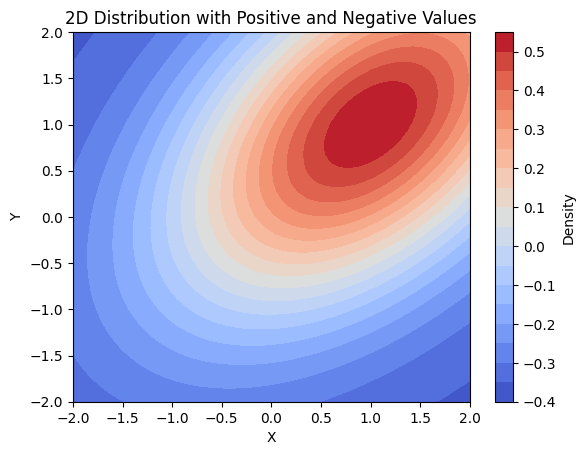

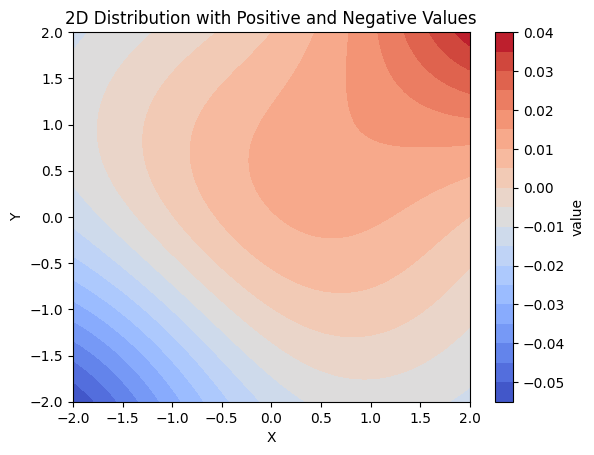

Training SHAP
Calibrating SHAP
Testing SHAP
Explaining Variables
Training SHAP
Calibrating SHAP
Testing SHAP
Explaining Variables
       X1_shap   X2_shap   X3_shap   X4_shap  x_coord_shap  y_coord_shap  \
0     0.473927  3.153835 -0.152241  0.344131      0.655841      0.125647   
1     1.541627 -1.332300 -0.297716  0.008937     -0.772127     -0.701646   
2     2.587910 -2.650946  0.144326  1.944166     -1.405546     -1.202946   
3     1.382449  3.303725  0.429653 -1.191429      0.177717     -0.543090   
4    -2.915839  0.115314 -0.739607  0.084575      1.317895      1.536515   
...        ...       ...       ...       ...           ...           ...   
2495 -7.201131 -2.434748 -1.174980  0.687012     -0.893905     -1.519493   
2496  1.998110 -2.029501 -0.927545 -1.342427      0.296942     -0.118495   
2497 -6.940217 -3.080512 -0.684641  0.976641     -0.684750     -1.352648   
2498 -2.068846 -3.024833 -0.572948  1.958710      0.063011     -0.579373   
2499  4.641900 -2.115183 -0.836633

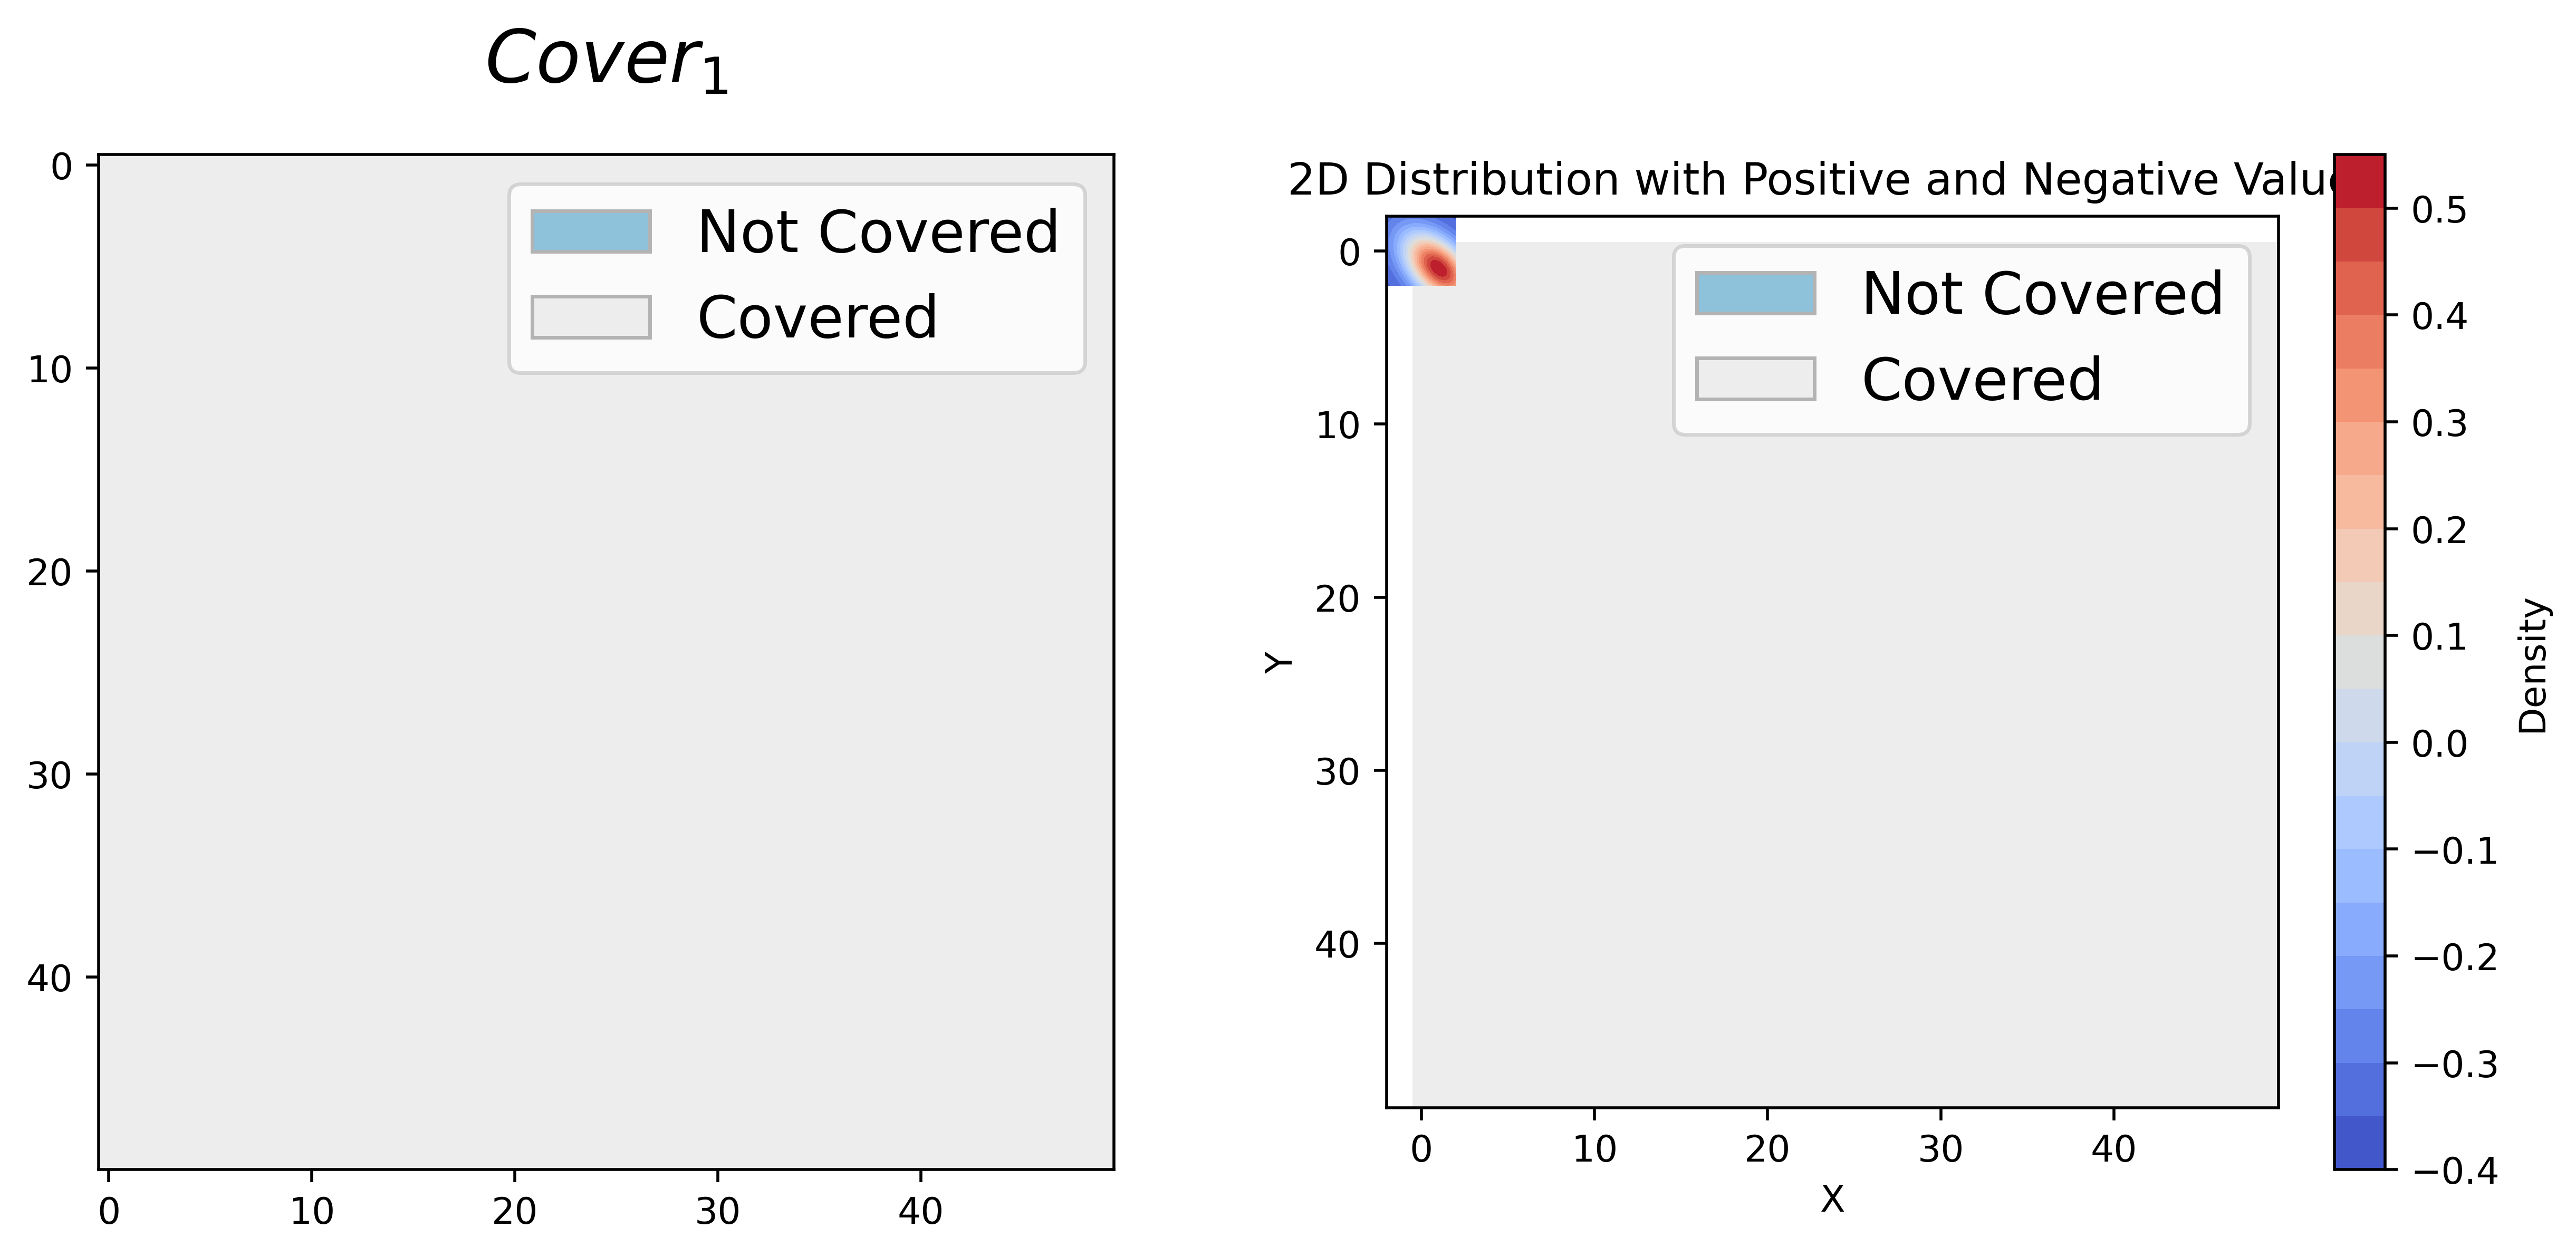

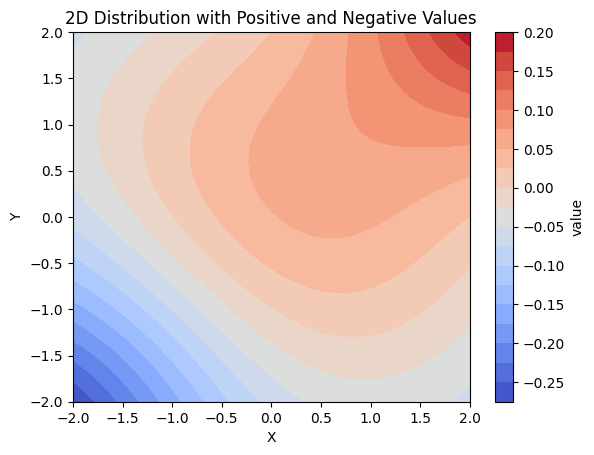

Training SHAP
Calibrating SHAP
Testing SHAP
Explaining Variables


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import shap
from matplotlib.colors import ListedColormap

def Eva(noise_level, cached_results=None, option=0):
    size = 50

    # 生成噪声数据
    # n1, n2 = noise_2d_generation(noise_level)
    n1, n2 = noise_uniform_generation(noise_level)
    current_combination = 'X1_only'
    if option == 0:
        current_combination = 'X1_only'
        n2 = np.zeros((size, size))
    elif option == 1:
        current_combination = 'X2_only'
        n1 = np.zeros((size, size))
    elif option == 2:
        current_combination = 'X1_and_X2'
        pass

    # 生成随机数据
    np.random.seed(222)
    X1 = np.random.uniform(-2, 2, size * size)
    X2 = np.random.uniform(-2, 2, size * size)
    X3 = np.random.uniform(-2, 2, size * size)
    X4 = np.random.uniform(-2, 2, size * size)
    X = np.vstack([X1, X2, X3, X4]).T

    # 生成坐标数据
    u = np.array([np.linspace(0, size - 1, num=size)] * size).reshape(-1)
    v = np.array([np.linspace(0, size - 1, num=size)] * size).T.reshape(-1)
    coords = np.array(list(zip(u, v)))

    # 构建 DataFrame
    X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1),
                            columns=['X1', 'X2', 'X3', 'X4', 'x_coord', 'y_coord'])

    # 划分训练、校准和测试集
    loc = X_coords[['x_coord', 'y_coord']]
    X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8)
    X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5)



    def true_model_predict_with_coeff_noise(X_coords):
        try:
            X_coords = X_coords.values
        except:
            pass
        u = X_coords[:, -1].astype(int)
        v = X_coords[:, -2].astype(int)
        b_1 = (u + v) / 49 * 3
        b_2 = 3 * (np.sin(-2 + 4 / 49 * u) * np.cos(-2 + 4 / 49 * v) + 1)
        f1 = (b_1 + n1[u, v]) * X_coords[:, 0]
        f2 = (b_2 + n2[u, v]) * X_coords[:, 1]
        f3 = X_coords[:, 2] ** 2
        f4 = np.abs(X_coords[:, 3]) * 2
        y_pred = f1 + f2 + f3 + f4
        return y_pred

    def true_model_predict(X_coords):
        try:
            X_coords = X_coords.values
        except:
            pass
        u = X_coords[:, -1].astype(int)
        v = X_coords[:, -2].astype(int)
        b_1 = (u + v) / 49 * 3
        b_2 = 3 * (np.sin(-2 + 4 / 49 * u) * np.cos(-2 + 4 / 49 * v) + 1)
        f1 = b_1 * X_coords[:, 0]
        f2 = b_2 * X_coords[:, 1]
        f3 = X_coords[:, 2] ** 2
        f4 = np.abs(X_coords[:, 3]) * 2
        y_pred = f1 + f2 + f3 + f4
        return y_pred


    # 如果 cached_results 为 None，则计算 results
    if cached_results is None:
        # 定义 SHAP 值计算函数
        def shap_value_f(x):
            explainer_ = shap.Explainer(true_model_predict, x, algorithm='auto')
            return explainer_(x).values

        # 初始化解释器
        explainer = GeoConformalizedExplainer(prediction_f=true_model_predict,
                                              x_train=X_train,
                                              x_calib=X_calib,
                                              coord_calib=loc_calib.values,
                                              miscoverage_level=0.1,
                                              band_width=25,
                                              shap_value_f=shap_value_f,
                                              feature_names=X_calib.columns)

        # 计算 SHAP 值
        results = explainer.uncertainty_aware_explain(x_test=X_coords, coord_test=loc.values)
        cached_results = results  # 缓存 results
    else:
        results = cached_results  # 使用缓存的 results

    # 定义带噪声的 SHAP 值计算函数
    def shap_value_f_with_noise(x):
        explainer_ = shap.Explainer(true_model_predict_with_coeff_noise, x, algorithm='auto')
        return explainer_(x).values

    # 初始化带噪声的解释器
    explainer_with_coef_noise = GeoConformalizedExplainer(prediction_f=true_model_predict_with_coeff_noise,
                                                          x_train=X_train,
                                                          x_calib=X_calib,
                                                          coord_calib=loc_calib.values,
                                                          miscoverage_level=0.1,
                                                          band_width=25,
                                                          shap_value_f=shap_value_f_with_noise,
                                                          feature_names=X_calib.columns)

    # 计算带噪声的 SHAP 值
    results_coef_noise = explainer_with_coef_noise.uncertainty_aware_explain(x_test=X_coords, coord_test=loc.values)

    # 提取结果
    pred_results = results.result_geo
    print(pred_results)
    pred_results_coef_noise = results_coef_noise.result_geo

    # 计算 MSE、RMSE 和 R²
    diff_X1 = pred_results_coef_noise.X1_shap - pred_results.X1_shap
    mse_X1 = np.mean(diff_X1**2)
    rmse_X1 = np.sqrt(mse_X1)
    r2_X1 = r2_score(pred_results.X1_shap, pred_results_coef_noise.X1_shap)

    diff_X2 = pred_results_coef_noise.X2_shap - pred_results.X2_shap
    mse_X2 = np.mean(diff_X2**2)
    rmse_X2 = np.sqrt(mse_X2)
    r2_X2 = r2_score(pred_results.X2_shap, pred_results_coef_noise.X2_shap)

    # 计算覆盖率
    pred_results_coef_noise['X1_upper_bound_new'] = pred_results_coef_noise['X1_shap'] + pred_results_coef_noise['X1_geo_uncertainty']
    pred_results_coef_noise['X1_lower_bound_new'] = pred_results_coef_noise['X1_shap'] - pred_results_coef_noise['X1_geo_uncertainty']
    pred_results_coef_noise['X2_upper_bound_new'] = pred_results_coef_noise['X2_shap'] + pred_results_coef_noise['X2_geo_uncertainty']
    pred_results_coef_noise['X2_lower_bound_new'] = pred_results_coef_noise['X2_shap'] - pred_results_coef_noise['X2_geo_uncertainty']

    X1_cover = (pred_results['X1_shap'] <= pred_results_coef_noise['X1_upper_bound_new']) & (
                pred_results['X1_shap'] >= pred_results_coef_noise['X1_lower_bound_new'])
    X2_cover = (pred_results['X2_shap'] <= pred_results_coef_noise['X2_upper_bound_new']) & (
                pred_results['X2_shap'] >= pred_results_coef_noise['X2_lower_bound_new'])

    # result_true_file = f'/content/drive/MyDrive/Research/0-Xiayin_research/2_Conformal SHAP//result_X2_{noise_level}_true.csv'
    # pred_results.to_csv(result_true_file)
    pred_results.to_csv(f'./results_multi_level_noise/results_{noise_level}_true-{current_combination}.csv')

    # result_noise_file = f'/content/drive/MyDrive/Research/0-Xiayin_research/2_Conformal SHAP//result_X2_{noise_level}_noise.csv'
    # pred_results_coef_noise.to_csv(result_noise_file)
    pred_results_coef_noise.to_csv(f'./results_multi_level_noise/results_{noise_level}_noise-{current_combination}.csv')

    # 计算覆盖率均值
    X1_cover_mean = X1_cover.mean()
    X2_cover_mean = X2_cover.mean()

    # 输出结果
    print(f"Noise Level: {noise_level}")
    print("MSE:", mse_X1)
    print("RMSE:", rmse_X1)
    print("R²:", r2_X1)
    print("X1 Coverage Mean:", X1_cover_mean)
    print("X2 Coverage Mean:", X2_cover_mean)

    # 可视化覆盖率
    b_cover = [X1_cover.values, X2_cover.values]
    sub_titles = [r'$Cover_1$', r'$Cover_2$']
    binary_cmap = ListedColormap(['#8ec1da', '#ededed'])
    plot_coverage(b_cover, k=2, sub_titles=sub_titles, colors=['#8ec1da', '#ededed'],
                  cmap=binary_cmap, filename=f'./results_multi_level_noise/Coverage-ConformalSHAP+Noise(Level={noise_level})-{current_combination}.pdf')


    result= pd.DataFrame({
        'noise_level': [noise_level],
        'mse': [mse_X1],
        'rmse': [rmse_X1],
        'r2': [r2_X1],
        'X1_cover_mean': [X1_cover_mean],
        'X2_cover_mean': [X2_cover_mean]
    })

    print("Returning result:", result)
    return result, cached_results  # 返回结果和缓存的 results

# 示例：循环不同的噪声水平
noise_levels = [1,5,10,20,40,50,60,70,80,90,100,150,200]

results_list = []
cached_results = None  # 初始化缓存的 results

for level in noise_levels:
    print(f"Processing noise level: {level}")
    result, cached_results = Eva(level, cached_results, option=2)  # 传入缓存的 results
    print(f"Appending result:\n{result}")
    results_list.append(result)  #
    print(f"Current results_list length: {len(results_list)}")

# 将结果转换为 DataFrame
results_df = pd.concat(results_list, ignore_index=True)  #

# outpath='/content/drive/MyDrive/Research/0-Xiayin_research/2_Conformal SHAP/result_x2.csv'
# results_df.to_csv(outpath)
results_df.to_csv(f'./results_multi_level_noise/results_multi_level_noise-X1_and_X2.csv')

print(results_df)

In [ ]:
results_list

In [ ]:
results_df

In [ ]:
outpath='/content/drive/MyDrive/Research/0-Xiayin_research/2_Conformal SHAP/result.csv'
results_df.to_csv(outpath)
